# Experiment: MSFT 1-Minute GRU Recursive Forecast (Stabilized)

This notebook implements the full recovery plan to address forecast collapse (linear drift/up-only bias):
- Alpaca `IEX` feed with free-plan-safe throttling
- Regular-trading-hours sessionization (09:30-15:59 ET)
- Return-space OHLC targets instead of raw absolute price targets
- Weighted Huber loss + AdamW + LR scheduler + early stopping
- Recursive 15-step forecast with train-quantile clipping guards
- Baselines, walk-forward evaluation, and acceptance checks


In [1]:
# Optional dependency bootstrap (lightweight)
import importlib.util
import subprocess
import sys

required = {
    'alpaca': 'alpaca-py',
    'numpy': 'numpy',
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
    'sklearn': 'scikit-learn',
}

missing = [pkg for module_name, pkg in required.items() if importlib.util.find_spec(module_name) is None]
if missing:
    print('Installing missing packages:', missing)
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *missing])
else:
    print('All required third-party packages are already installed.')

print('Install PyTorch separately with the correct CUDA wheel for your RTX 3070.')


All required third-party packages are already installed.
Install PyTorch separately with the correct CUDA wheel for your RTX 3070.


In [2]:
# Setup: imports and reproducibility
from __future__ import annotations

import copy
import os
import random
import time
from dataclasses import dataclass
from datetime import datetime, timedelta, timezone

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from alpaca.data.enums import DataFeed
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Rectangle
from torch.utils.data import DataLoader, Dataset

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.benchmark = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {DEVICE}')
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))
    print('CUDA:', torch.version.cuda)


Using device: cuda
GPU: NVIDIA GeForce RTX 3070
CUDA: 12.1


## Configuration

Locked defaults from the fix plan:
- `ALPACA_FEED='iex'`
- `USE_RTH_ONLY=True` with ET sessionization
- `TARGET_MODE='log_return_ohlc'`
- `LOSS_TYPE='weighted_huber'`
- `MAX_REQUESTS_PER_MINUTE=120`
- `CLIP_TARGET_QUANTILES=(0.005, 0.995)`


In [3]:
# Experiment configuration
SYMBOL = 'MSFT'
LOOKBACK_DAYS = 60
FEATURES = ['Open', 'High', 'Low', 'Close']

WINDOW = 500
HORIZON = 15
TARGET_MODE = 'log_return_ohlc'

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15

BATCH_SIZE = 256
HIDDEN_SIZE = 128
NUM_LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
MAX_EPOCHS = 30
EARLY_STOPPING_PATIENCE = 6
LOSS_TYPE = 'weighted_huber'
HUBER_DELTA = 1.0
LOSS_WEIGHTS = np.array([1.0, 1.0, 1.0, 2.0], dtype=np.float32)
CLIP_TARGET_QUANTILES = (0.005, 0.995)

# Alpaca + sessionization
ALPACA_FEED = os.getenv('ALPACA_FEED', 'iex').strip().lower()
USE_RTH_ONLY = True
SESSION_TZ = 'America/New_York'
RTH_START = '09:30'
RTH_END = '16:00'
REQUEST_CHUNK_DAYS = 5
MAX_REQUESTS_PER_MINUTE = 120
MAX_RETRIES = 5

print({
    'symbol': SYMBOL,
    'lookback_days': LOOKBACK_DAYS,
    'window': WINDOW,
    'horizon': HORIZON,
    'target_mode': TARGET_MODE,
    'loss_type': LOSS_TYPE,
    'alpaca_feed': ALPACA_FEED,
    'use_rth_only': USE_RTH_ONLY,
    'session_tz': SESSION_TZ,
    'max_requests_per_minute': MAX_REQUESTS_PER_MINUTE,
    'device': str(DEVICE),
})


{'symbol': 'MSFT', 'lookback_days': 60, 'window': 500, 'horizon': 15, 'target_mode': 'log_return_ohlc', 'loss_type': 'weighted_huber', 'alpaca_feed': 'iex', 'use_rth_only': True, 'session_tz': 'America/New_York', 'max_requests_per_minute': 120, 'device': 'cuda'}


In [4]:
# Data ingestion, rate-limit-safe pulling, and RTH sessionization
class RequestPacer:
    def __init__(self, max_calls_per_minute: int):
        if max_calls_per_minute <= 0:
            raise ValueError('max_calls_per_minute must be > 0')
        self.min_interval = 60.0 / float(max_calls_per_minute)
        self.last_call_ts = 0.0

    def wait(self) -> None:
        now = time.monotonic()
        elapsed = now - self.last_call_ts
        if elapsed < self.min_interval:
            time.sleep(self.min_interval - elapsed)
        self.last_call_ts = time.monotonic()


def _require_alpaca_credentials() -> tuple[str, str]:
    api_key = os.getenv('ALPACA_API_KEY')
    secret_key = os.getenv('ALPACA_SECRET_KEY')
    if not api_key or not secret_key:
        raise RuntimeError(
            'Missing Alpaca credentials. Set ALPACA_API_KEY and ALPACA_SECRET_KEY before running this notebook.'
        )
    return api_key, secret_key


def _resolve_feed(feed_name: str) -> DataFeed:
    mapping = {
        'iex': DataFeed.IEX,
        'sip': DataFeed.SIP,
        'delayed_sip': DataFeed.DELAYED_SIP,
    }
    key = feed_name.strip().lower()
    if key not in mapping:
        raise ValueError(f'Unsupported ALPACA_FEED={feed_name!r}. Use one of: {list(mapping)}')
    return mapping[key]


def fetch_ohlc_1m_alpaca(
    symbol: str,
    lookback_days: int,
    feed_name: str,
    chunk_days: int,
    max_calls_per_minute: int,
    max_retries: int = 5,
) -> tuple[pd.DataFrame, int]:
    api_key, secret_key = _require_alpaca_credentials()
    client = StockHistoricalDataClient(api_key=api_key, secret_key=secret_key)

    feed = _resolve_feed(feed_name)
    pacer = RequestPacer(max_calls_per_minute=max_calls_per_minute)

    end_ts = datetime.now(timezone.utc).replace(second=0, microsecond=0)
    if feed_name in {'sip', 'delayed_sip'}:
        end_ts = end_ts - timedelta(minutes=20)

    start_ts = end_ts - timedelta(days=lookback_days)

    frames: list[pd.DataFrame] = []
    cursor = start_ts
    api_call_count = 0

    while cursor < end_ts:
        chunk_end = min(cursor + timedelta(days=chunk_days), end_ts)
        bars = None

        for attempt in range(1, max_retries + 1):
            pacer.wait()
            api_call_count += 1
            try:
                req = StockBarsRequest(
                    symbol_or_symbols=[symbol],
                    timeframe=TimeFrame.Minute,
                    start=cursor,
                    end=chunk_end,
                    feed=feed,
                    limit=10_000,
                )
                bars = client.get_stock_bars(req).df
                break
            except Exception as exc:
                msg = str(exc).lower()

                if ('429' in msg or 'rate limit' in msg) and attempt < max_retries:
                    backoff = min(2 ** attempt, 30)
                    print(
                        f'Rate limit response on chunk {cursor} -> {chunk_end}; '
                        f'sleeping {backoff}s (attempt {attempt}/{max_retries}).'
                    )
                    time.sleep(backoff)
                    continue

                if ('subscription' in msg or 'forbidden' in msg) and feed_name != 'iex':
                    raise RuntimeError(
                        f'Feed {feed_name!r} is unavailable for this account. '
                        'Set ALPACA_FEED=iex or upgrade your data subscription.'
                    ) from exc

                raise

        if bars is not None and not bars.empty:
            chunk_df = bars.reset_index()
            chunk_df = chunk_df.rename(
                columns={
                    'timestamp': 'Datetime',
                    'open': 'Open',
                    'high': 'High',
                    'low': 'Low',
                    'close': 'Close',
                }
            )

            needed = ['Datetime', 'Open', 'High', 'Low', 'Close']
            missing = [c for c in needed if c not in chunk_df.columns]
            if missing:
                raise RuntimeError(f'Alpaca response missing required columns: {missing}')

            chunk_df['Datetime'] = pd.to_datetime(chunk_df['Datetime'], utc=True)
            chunk_df = chunk_df[needed].dropna().set_index('Datetime').sort_index()
            frames.append(chunk_df)

        cursor = chunk_end

    if not frames:
        raise RuntimeError('No bars returned from Alpaca. Verify symbol, credentials, feed, and market session.')

    df = pd.concat(frames, axis=0).sort_index()
    df = df[~df.index.duplicated(keep='last')]
    df = df.dropna(subset=FEATURES)
    return df.astype(np.float32), api_call_count


def sessionize_regular_hours(
    df_utc: pd.DataFrame,
    tz_name: str,
    start_hhmm: str,
    end_hhmm: str,
    use_rth_only: bool = True,
) -> tuple[pd.DataFrame, dict]:
    if df_utc.empty:
        raise RuntimeError('Input dataframe is empty before sessionization.')

    local = df_utc.copy()
    local.index = pd.DatetimeIndex(local.index).tz_convert(tz_name)

    local = local[local.index.dayofweek < 5]

    if use_rth_only:
        local = local.between_time(start_hhmm, end_hhmm, inclusive='left')

    if local.empty:
        raise RuntimeError('No bars remain after weekday/RTH filtering.')

    session_dates = pd.Index(local.index.date).unique().tolist()
    raw_counts = {d: int((local.index.date == d).sum()) for d in session_dates}

    if not raw_counts:
        raise RuntimeError('No sessions found after filtering.')

    latest_date = max(raw_counts.keys())
    drop_latest = raw_counts[latest_date] < 390

    session_frames = []
    kept_dates = []
    fill_counts = {}

    for d in session_dates:
        if drop_latest and d == latest_date:
            continue

        day_df = local[local.index.date == d][FEATURES].copy()

        day_start = pd.Timestamp(f'{d} {start_hhmm}', tz=tz_name)
        expected_idx = pd.date_range(day_start, periods=390, freq='1min')

        reindexed = day_df.reindex(expected_idx)
        missing_before = int(reindexed[FEATURES].isna().any(axis=1).sum())

        reindexed[FEATURES] = reindexed[FEATURES].ffill().bfill()

        if reindexed[FEATURES].isna().any().any():
            raise RuntimeError(f'Session {d} still contains NaNs after fill.')

        session_frames.append(reindexed)
        kept_dates.append(d)
        fill_counts[d] = missing_before

    if not session_frames:
        raise RuntimeError('No complete sessions remain after dropping incomplete latest session.')

    out = pd.concat(session_frames, axis=0).sort_index()

    grouped_sizes = out.groupby(out.index.date).size()
    if not bool((grouped_sizes == 390).all()):
        raise AssertionError('Integrity check failed: each kept session must have exactly 390 bars.')

    if out[FEATURES].isna().any().any():
        raise AssertionError('Integrity check failed: NaNs present after sessionization.')

    out.index = out.index.tz_localize(None)

    meta = {
        'raw_sessions': len(session_dates),
        'kept_sessions': len(kept_dates),
        'dropped_latest_session': bool(drop_latest),
        'latest_session_raw_count': int(raw_counts[latest_date]),
        'avg_filled_bars_per_session': float(np.mean(list(fill_counts.values()))) if fill_counts else 0.0,
    }

    return out.astype(np.float32), meta


raw_df_utc, api_calls = fetch_ohlc_1m_alpaca(
    symbol=SYMBOL,
    lookback_days=LOOKBACK_DAYS,
    feed_name=ALPACA_FEED,
    chunk_days=REQUEST_CHUNK_DAYS,
    max_calls_per_minute=MAX_REQUESTS_PER_MINUTE,
    max_retries=MAX_RETRIES,
)

price_df, session_meta = sessionize_regular_hours(
    raw_df_utc,
    tz_name=SESSION_TZ,
    start_hhmm=RTH_START,
    end_hhmm=RTH_END,
    use_rth_only=USE_RTH_ONLY,
)

span_days = (price_df.index.max() - price_df.index.min()).total_seconds() / 86400
print(f'Raw rows from Alpaca: {len(raw_df_utc):,}')
print(f'Sessionized rows: {len(price_df):,}')
print(f'Time span after sessionization: {span_days:.1f} days')
print(f'Alpaca API calls: {api_calls} (throttled to <= {MAX_REQUESTS_PER_MINUTE}/min)')
print('Session meta:', session_meta)

min_needed = WINDOW + HORIZON + 500
if len(price_df) < min_needed:
    raise RuntimeError(
        f'Not enough sessionized rows ({len(price_df)}) for robust training. Need at least {min_needed}.'
    )

display(price_df.head(3))
display(price_df.tail(3))


Raw rows from Alpaca: 15,082
Sessionized rows: 15,210
Time span after sessionization: 59.3 days
Alpaca API calls: 12 (throttled to <= 120/min)
Session meta: {'raw_sessions': 39, 'kept_sessions': 39, 'dropped_latest_session': False, 'latest_session_raw_count': 390, 'avg_filled_bars_per_session': 8.58974358974359}


,Open,High,Low,Close
2025-12-12 09:30:00,479.980011,480.700012,478.864990,480.644989
2025-12-12 09:31:00,480.420013,482.160004,480.165009,481.970001
2025-12-12 09:32:00,481.709991,481.829987,481.339996,481.654999


,Open,High,Low,Close
2026-02-09 15:57:00,413.480011,414.130005,413.399994,414.049988
2026-02-09 15:58:00,414.029999,414.179993,414.029999,414.109985
2026-02-09 15:59:00,414.065002,414.149994,413.559998,413.690002


In [5]:
# Transform utilities (prices <-> return targets) with correctness checks
def prices_to_targets(price_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    prev_close = price_df['Close'].shift(1)
    valid = prev_close.notna()

    base = prev_close[valid]
    tgt = pd.DataFrame(index=price_df.index[valid], dtype=np.float32)

    tgt['Open'] = np.log(price_df.loc[valid, 'Open'] / base)
    tgt['High'] = np.log(price_df.loc[valid, 'High'] / base)
    tgt['Low'] = np.log(price_df.loc[valid, 'Low'] / base)
    tgt['Close'] = np.log(price_df.loc[valid, 'Close'] / base)

    return tgt.astype(np.float32), base.astype(np.float32)


def enforce_candle_validity(ohlc: np.ndarray) -> np.ndarray:
    out = np.asarray(ohlc, dtype=np.float32).copy()
    o = out[:, 0]
    h = out[:, 1]
    l = out[:, 2]
    c = out[:, 3]

    out[:, 1] = np.maximum.reduce([h, o, c])
    out[:, 2] = np.minimum.reduce([l, o, c])
    return out


def targets_to_prices_seq(pred_targets: np.ndarray, last_close: float) -> np.ndarray:
    seq = []
    prev_close = float(last_close)

    for rO, rH, rL, rC in np.asarray(pred_targets, dtype=np.float32):
        o = prev_close * np.exp(float(rO))
        h = prev_close * np.exp(float(rH))
        l = prev_close * np.exp(float(rL))
        c = prev_close * np.exp(float(rC))

        cand = np.array([[o, h, l, c]], dtype=np.float32)
        cand = enforce_candle_validity(cand)[0]
        seq.append(cand)
        prev_close = float(cand[3])

    return np.asarray(seq, dtype=np.float32)


def one_step_targets_to_prices_batch(pred_targets: np.ndarray, prev_close: np.ndarray) -> np.ndarray:
    pred_targets = np.asarray(pred_targets, dtype=np.float32)
    prev_close = np.asarray(prev_close, dtype=np.float32)

    o = prev_close * np.exp(pred_targets[:, 0])
    h = prev_close * np.exp(pred_targets[:, 1])
    l = prev_close * np.exp(pred_targets[:, 2])
    c = prev_close * np.exp(pred_targets[:, 3])

    out = np.stack([o, h, l, c], axis=1).astype(np.float32)
    return enforce_candle_validity(out)


targets_df, prev_close_series = prices_to_targets(price_df)
print('Price rows:', len(price_df), 'Target rows:', len(targets_df))

# Round-trip test on early segment (price -> returns -> prices)
round_n = min(1500, len(price_df))
round_df = price_df.iloc[:round_n].copy()
round_targets, _ = prices_to_targets(round_df)
round_recon = targets_to_prices_seq(round_targets.to_numpy(np.float32), float(round_df['Close'].iloc[0]))
round_actual = round_df[FEATURES].iloc[1:].to_numpy(np.float32)

rt_max_abs = float(np.max(np.abs(round_recon - round_actual)))
rt_mean_abs = float(np.mean(np.abs(round_recon - round_actual)))
print({'roundtrip_max_abs_error': rt_max_abs, 'roundtrip_mean_abs_error': rt_mean_abs})
assert rt_max_abs < 1e-3, 'Round-trip transform error too large.'


Price rows: 15210 Target rows: 15209
{'roundtrip_max_abs_error': 0.000701904296875, 'roundtrip_mean_abs_error': 0.00028088793624192476}


In [6]:
# Split/window utilities and walk-forward slice definitions
def fit_standardizer(train_values: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    mean = train_values.mean(axis=0)
    std = train_values.std(axis=0)
    std = np.where(std < 1e-8, 1.0, std)
    return mean.astype(np.float32), std.astype(np.float32)


def apply_standardizer(values: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return ((values - mean) / std).astype(np.float32)


def undo_standardizer(values_scaled: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return (values_scaled * std + mean).astype(np.float32)


def make_windows(values: np.ndarray, window: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    X, y, idx = [], [], []
    for i in range(window, len(values)):
        X.append(values[i - window : i])
        y.append(values[i])
        idx.append(i)

    return (
        np.asarray(X, dtype=np.float32),
        np.asarray(y, dtype=np.float32),
        np.asarray(idx, dtype=np.int64),
    )


def build_walkforward_slices(price_df_full: pd.DataFrame) -> list[tuple[str, int, int]]:
    n = len(price_df_full)
    span = int(round(n * 0.85))
    shift = max(1, n - span)

    s1 = (0, min(span, n))
    s2 = (shift, min(shift + span, n))

    slices = [('slice_1', s1[0], s1[1]), ('slice_2', s2[0], s2[1])]

    unique = []
    seen = set()
    for name, a, b in slices:
        key = (a, b)
        if key in seen:
            continue
        if b - a < (WINDOW + HORIZON + 1000):
            continue
        unique.append((name, a, b))
        seen.add(key)

    if not unique:
        raise RuntimeError('Unable to construct walk-forward slices with enough rows.')

    return unique


class SequenceDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int):
        return self.X[idx], self.y[idx]


slices = build_walkforward_slices(price_df)
print('Walk-forward slices:', slices)


Walk-forward slices: [('slice_1', 0, 12928), ('slice_2', 2282, 15210)]


In [7]:
# Model, loss, and training utilities
class GRUForecaster(nn.Module):
    def __init__(self, input_size: int = 4, hidden_size: int = 128, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Linear(hidden_size, input_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, _ = self.gru(x)
        return self.head(out[:, -1, :])


class WeightedHuberLoss(nn.Module):
    def __init__(self, weights: np.ndarray, delta: float = 1.0):
        super().__init__()
        w = torch.as_tensor(weights, dtype=torch.float32)
        self.register_buffer('weights', w)
        self.delta = float(delta)

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        err = pred - target
        abs_err = torch.abs(err)
        huber = torch.where(
            abs_err <= self.delta,
            0.5 * (err ** 2),
            self.delta * (abs_err - 0.5 * self.delta),
        )
        weighted = huber * self.weights
        return weighted.mean()


def run_epoch(model: nn.Module, loader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer | None = None) -> float:
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    total_items = 0

    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            pred = model(xb)
            loss = loss_fn(pred, yb)

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        bs = xb.size(0)
        total_loss += loss.item() * bs
        total_items += bs

    return total_loss / max(total_items, 1)


def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader) -> pd.DataFrame:
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-5,
    )

    loss_fn = WeightedHuberLoss(weights=LOSS_WEIGHTS, delta=HUBER_DELTA).to(DEVICE)

    best_val = float('inf')
    best_state = copy.deepcopy(model.state_dict())
    wait = 0
    rows = []

    for epoch in range(1, MAX_EPOCHS + 1):
        train_loss = run_epoch(model, train_loader, loss_fn, optimizer=optimizer)
        val_loss = run_epoch(model, val_loader, loss_fn, optimizer=None)
        scheduler.step(val_loss)

        lr = optimizer.param_groups[0]['lr']
        rows.append({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'lr': lr})

        print(f'Epoch {epoch:02d} | train={train_loss:.6f} | val={val_loss:.6f} | lr={lr:.6g}')

        if val_loss < best_val:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= EARLY_STOPPING_PATIENCE:
                print(f'Early stopping at epoch {epoch}.')
                break

    model.load_state_dict(best_state)
    return pd.DataFrame(rows)


In [8]:
# Metrics, baselines, recursive rollout, and fold runner
def rmse(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.sqrt(np.mean((np.asarray(a) - np.asarray(b)) ** 2)))


def evaluate_metrics(actual_ohlc: np.ndarray, pred_ohlc: np.ndarray, prev_close: np.ndarray) -> dict:
    actual_ohlc = np.asarray(actual_ohlc, dtype=np.float32)
    pred_ohlc = np.asarray(pred_ohlc, dtype=np.float32)
    prev_close = np.asarray(prev_close, dtype=np.float32)

    actual_close = actual_ohlc[:, 3]
    pred_close = pred_ohlc[:, 3]

    out = {
        'close_mae': float(np.mean(np.abs(actual_close - pred_close))),
        'close_rmse': rmse(actual_close, pred_close),
        'ohlc_mae': float(np.mean(np.abs(actual_ohlc - pred_ohlc))),
        'ohlc_rmse': rmse(actual_ohlc.reshape(-1), pred_ohlc.reshape(-1)),
        'directional_accuracy': float(np.mean(np.sign(actual_close - prev_close) == np.sign(pred_close - prev_close))),
        'mean_signed_bias': float(np.mean(pred_close - actual_close)),
    }
    return out


def evaluate_baselines(actual_ohlc: np.ndarray, prev_ohlc: np.ndarray, prev_close: np.ndarray) -> dict:
    baseline_persistence = evaluate_metrics(actual_ohlc, prev_ohlc, prev_close)

    flat = np.repeat(prev_close.reshape(-1, 1), 4, axis=1).astype(np.float32)
    baseline_flat = evaluate_metrics(actual_ohlc, flat, prev_close)

    return {'persistence': baseline_persistence, 'flat_close_rw': baseline_flat}


@torch.no_grad()
def collect_preds(model: nn.Module, loader: DataLoader) -> tuple[np.ndarray, np.ndarray]:
    model.eval()
    preds = []
    targets = []

    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yhat = model(xb).cpu().numpy()
        preds.append(yhat)
        targets.append(yb.numpy())

    return np.vstack(preds).astype(np.float32), np.vstack(targets).astype(np.float32)


@torch.no_grad()
def recursive_forecast_returns(
    model: nn.Module,
    seed_window_scaled: np.ndarray,
    horizon: int,
    scale_mean: np.ndarray,
    scale_std: np.ndarray,
    clip_low: np.ndarray,
    clip_high: np.ndarray,
) -> np.ndarray:
    model.eval()
    window = seed_window_scaled.copy().astype(np.float32)
    preds = []

    for _ in range(horizon):
        x = torch.from_numpy(window).float().unsqueeze(0).to(DEVICE)
        pred_scaled = model(x).cpu().numpy()[0]

        pred_ret = undo_standardizer(pred_scaled.reshape(1, -1), scale_mean, scale_std)[0]
        pred_ret = np.clip(pred_ret, clip_low, clip_high).astype(np.float32)

        pred_scaled_clipped = apply_standardizer(pred_ret.reshape(1, -1), scale_mean, scale_std)[0]

        preds.append(pred_ret)
        window = np.vstack([window[1:], pred_scaled_clipped]).astype(np.float32)

    return np.asarray(preds, dtype=np.float32)


def evaluate_recursive_by_horizon(
    model: nn.Module,
    returns_scaled: np.ndarray,
    price_ohlc: np.ndarray,
    close_values: np.ndarray,
    anchors: list[int],
    horizon: int,
    scale_mean: np.ndarray,
    scale_std: np.ndarray,
    clip_low: np.ndarray,
    clip_high: np.ndarray,
) -> pd.DataFrame:
    model_err = [[] for _ in range(horizon)]
    persist_err = [[] for _ in range(horizon)]
    flat_err = [[] for _ in range(horizon)]

    for anchor in anchors:
        seed = returns_scaled[anchor - WINDOW + 1 : anchor + 1]
        last_close = float(close_values[anchor + 1])

        pred_ret = recursive_forecast_returns(
            model=model,
            seed_window_scaled=seed,
            horizon=horizon,
            scale_mean=scale_mean,
            scale_std=scale_std,
            clip_low=clip_low,
            clip_high=clip_high,
        )
        pred_price = targets_to_prices_seq(pred_ret, last_close=last_close)

        actual = price_ohlc[anchor + 2 : anchor + 2 + horizon]

        persist_seq = np.repeat(price_ohlc[anchor + 1 : anchor + 2], horizon, axis=0)
        flat_c = close_values[anchor + 1]
        flat_seq = np.repeat(np.array([[flat_c, flat_c, flat_c, flat_c]], dtype=np.float32), horizon, axis=0)

        for h in range(horizon):
            model_err[h].append(abs(float(pred_price[h, 3] - actual[h, 3])))
            persist_err[h].append(abs(float(persist_seq[h, 3] - actual[h, 3])))
            flat_err[h].append(abs(float(flat_seq[h, 3] - actual[h, 3])))

    rows = []
    for h in range(horizon):
        rows.append({
            'horizon': h + 1,
            'model_close_mae': float(np.mean(model_err[h])) if model_err[h] else np.nan,
            'persistence_close_mae': float(np.mean(persist_err[h])) if persist_err[h] else np.nan,
            'flat_close_mae': float(np.mean(flat_err[h])) if flat_err[h] else np.nan,
        })

    return pd.DataFrame(rows)


def split_points(n_rows: int) -> tuple[int, int]:
    train_end = int(n_rows * TRAIN_RATIO)
    val_end = int(n_rows * (TRAIN_RATIO + VAL_RATIO))
    return train_end, val_end


def overfit_sanity_check(X_train: np.ndarray, y_train: np.ndarray) -> dict:
    n = min(1000, len(X_train))
    if n < 300:
        return {'ran': False, 'reason': 'too_few_train_samples'}

    Xs = X_train[:n]
    ys = y_train[:n]

    ds = SequenceDataset(Xs, ys)
    dl = DataLoader(ds, batch_size=128, shuffle=True, drop_last=False)

    model = GRUForecaster(input_size=4, hidden_size=64, num_layers=1, dropout=0.0).to(DEVICE)
    loss_fn = WeightedHuberLoss(weights=LOSS_WEIGHTS, delta=HUBER_DELTA).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

    init_loss = run_epoch(model, dl, loss_fn, optimizer=None)
    for _ in range(12):
        _ = run_epoch(model, dl, loss_fn, optimizer=opt)
    final_loss = run_epoch(model, dl, loss_fn, optimizer=None)

    passed = bool(final_loss < init_loss * 0.6)
    return {'ran': True, 'initial_loss': float(init_loss), 'final_loss': float(final_loss), 'passed': passed}


def run_fold(fold_name: str, price_fold: pd.DataFrame, run_sanity: bool = False) -> dict:
    targets_fold, prev_close_fold = prices_to_targets(price_fold)

    ret_values = targets_fold[FEATURES].to_numpy(np.float32)
    prev_close_values = prev_close_fold.to_numpy(np.float32)

    price_values = price_fold[FEATURES].to_numpy(np.float32)
    close_values = price_fold['Close'].to_numpy(np.float32)

    train_end, val_end = split_points(len(ret_values))

    if train_end <= WINDOW or val_end <= train_end:
        raise RuntimeError(f'{fold_name}: invalid split points for return rows={len(ret_values)}')

    scale_mean, scale_std = fit_standardizer(ret_values[:train_end])
    ret_scaled = apply_standardizer(ret_values, scale_mean, scale_std)

    q_low, q_high = CLIP_TARGET_QUANTILES
    clip_low = np.quantile(ret_values[:train_end], q_low, axis=0).astype(np.float32)
    clip_high = np.quantile(ret_values[:train_end], q_high, axis=0).astype(np.float32)

    X_all, y_all, target_idx = make_windows(ret_scaled, WINDOW)

    train_mask = target_idx < train_end
    val_mask = (target_idx >= train_end) & (target_idx < val_end)
    test_mask = target_idx >= val_end

    X_train, y_train = X_all[train_mask], y_all[train_mask]
    X_val, y_val = X_all[val_mask], y_all[val_mask]
    X_test, y_test = X_all[test_mask], y_all[test_mask]

    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
        raise RuntimeError(f'{fold_name}: one or more splits are empty after windowing.')

    sanity = overfit_sanity_check(X_train, y_train) if run_sanity else {'ran': False}

    train_loader = DataLoader(SequenceDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    val_loader = DataLoader(SequenceDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
    test_loader = DataLoader(SequenceDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    model = GRUForecaster(input_size=4, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT).to(DEVICE)
    history_df = train_model(model, train_loader, val_loader)

    pred_scaled, y_scaled = collect_preds(model, test_loader)
    pred_ret = undo_standardizer(pred_scaled, scale_mean, scale_std)
    y_ret = undo_standardizer(y_scaled, scale_mean, scale_std)

    test_idx = target_idx[test_mask]

    prev_close_t = prev_close_values[test_idx]
    actual_ohlc = price_values[test_idx + 1]

    pred_ohlc = one_step_targets_to_prices_batch(pred_ret, prev_close_t)
    prev_ohlc = price_values[test_idx]

    model_metrics = evaluate_metrics(actual_ohlc, pred_ohlc, prev_close_t)
    baseline_metrics = evaluate_baselines(actual_ohlc, prev_ohlc, prev_close_t)

    anchors = sorted(set(int(i - 1) for i in test_idx))
    max_anchor = len(ret_values) - HORIZON - 1
    anchors = [a for a in anchors if a >= (WINDOW - 1) and a <= max_anchor]
    if not anchors:
        raise RuntimeError(f'{fold_name}: no eligible anchors for recursive evaluation.')

    horizon_df = evaluate_recursive_by_horizon(
        model=model,
        returns_scaled=ret_scaled,
        price_ohlc=price_values,
        close_values=close_values,
        anchors=anchors,
        horizon=HORIZON,
        scale_mean=scale_mean,
        scale_std=scale_std,
        clip_low=clip_low,
        clip_high=clip_high,
    )

    last_anchor = anchors[-1]
    seed_scaled = ret_scaled[last_anchor - WINDOW + 1 : last_anchor + 1]
    last_close = float(close_values[last_anchor + 1])

    pred_ret_path = recursive_forecast_returns(
        model=model,
        seed_window_scaled=seed_scaled,
        horizon=HORIZON,
        scale_mean=scale_mean,
        scale_std=scale_std,
        clip_low=clip_low,
        clip_high=clip_high,
    )
    pred_price_path = targets_to_prices_seq(pred_ret_path, last_close=last_close)
    actual_price_path = price_values[last_anchor + 2 : last_anchor + 2 + HORIZON]

    future_index = price_fold.index[last_anchor + 2 : last_anchor + 2 + HORIZON]
    pred_future_df = pd.DataFrame(pred_price_path, index=future_index, columns=FEATURES)
    actual_future_df = pd.DataFrame(actual_price_path, index=future_index, columns=FEATURES)

    known_pos = last_anchor + 1
    context_bars = 170
    c_start = max(0, known_pos - context_bars + 1)
    context_df = price_fold.iloc[c_start : known_pos + 1][FEATURES].copy()

    step15_row = horizon_df[horizon_df['horizon'] == HORIZON].iloc[0]

    out = {
        'fold': fold_name,
        'history_df': history_df,
        'model_metrics': model_metrics,
        'baseline_metrics': baseline_metrics,
        'horizon_df': horizon_df,
        'context_df': context_df,
        'actual_future_df': actual_future_df,
        'pred_future_df': pred_future_df,
        'pred_ret_path': pred_ret_path,
        'sanity': sanity,
        'samples': {
            'train': int(len(X_train)),
            'val': int(len(X_val)),
            'test': int(len(X_test)),
            'anchors': int(len(anchors)),
        },
        'step15': {
            'model_close_mae': float(step15_row['model_close_mae']),
            'persistence_close_mae': float(step15_row['persistence_close_mae']),
            'flat_close_mae': float(step15_row['flat_close_mae']),
        },
    }
    return out


In [9]:
# Run walk-forward folds
fold_results = []

for i, (name, start_i, end_i) in enumerate(slices, start=1):
    print(f'\n=== Running {name} [{start_i}:{end_i}] ===')
    fold_price = price_df.iloc[start_i:end_i].copy()

    result = run_fold(name, fold_price, run_sanity=(i == 1))
    fold_results.append(result)

    print('Sample counts:', result['samples'])
    print('Sanity check:', result['sanity'])
    print('One-step model:', result['model_metrics'])
    print('One-step persistence:', result['baseline_metrics']['persistence'])
    print('One-step flat_close_rw:', result['baseline_metrics']['flat_close_rw'])
    print('Recursive step-15:', result['step15'])

if not fold_results:
    raise RuntimeError('No fold results were produced.')

summary_rows = []
for r in fold_results:
    m = r['model_metrics']
    b1 = r['baseline_metrics']['persistence']
    b2 = r['baseline_metrics']['flat_close_rw']
    s15 = r['step15']

    summary_rows.append({
        'fold': r['fold'],
        'model_close_mae': m['close_mae'],
        'model_directional_acc': m['directional_accuracy'],
        'model_mean_signed_bias': m['mean_signed_bias'],
        'persistence_close_mae': b1['close_mae'],
        'flat_close_mae': b2['close_mae'],
        'recursive_step15_model_mae': s15['model_close_mae'],
        'recursive_step15_persistence_mae': s15['persistence_close_mae'],
        'recursive_step15_flat_mae': s15['flat_close_mae'],
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

metric_cols = [c for c in summary_df.columns if c != 'fold']
agg_df = pd.DataFrame({'mean': summary_df[metric_cols].mean(), 'std': summary_df[metric_cols].std(ddof=0)})
display(agg_df)

horizon_all = pd.concat([r['horizon_df'].assign(fold=r['fold']) for r in fold_results], ignore_index=True)
horizon_stats = horizon_all.groupby('horizon', as_index=False)[['model_close_mae', 'persistence_close_mae', 'flat_close_mae']].mean()
display(horizon_stats)



=== Running slice_1 [0:12928] ===
Epoch 01 | train=0.340293 | val=0.567970 | lr=0.001
Epoch 02 | train=0.333749 | val=0.569170 | lr=0.001
Epoch 03 | train=0.332564 | val=0.568382 | lr=0.001
Epoch 04 | train=0.332251 | val=0.567395 | lr=0.001
Epoch 05 | train=0.331784 | val=0.566455 | lr=0.001
Epoch 06 | train=0.331598 | val=0.566906 | lr=0.001
Epoch 07 | train=0.331109 | val=0.566005 | lr=0.001
Epoch 08 | train=0.331066 | val=0.567023 | lr=0.001
Epoch 09 | train=0.330684 | val=0.567306 | lr=0.001
Epoch 10 | train=0.330260 | val=0.565405 | lr=0.001
Epoch 11 | train=0.329872 | val=0.566936 | lr=0.001
Epoch 12 | train=0.329857 | val=0.566447 | lr=0.001
Epoch 13 | train=0.329509 | val=0.567092 | lr=0.0005
Epoch 14 | train=0.327751 | val=0.567976 | lr=0.0005
Epoch 15 | train=0.327837 | val=0.569674 | lr=0.0005
Epoch 16 | train=0.327271 | val=0.567444 | lr=0.00025
Early stopping at epoch 16.
Sample counts: {'train': 8548, 'val': 1939, 'test': 1940, 'anchors': 1926}
Sanity check: {'ran': Tru

,fold,model_close_mae,model_directional_acc,model_mean_signed_bias,persistence_close_mae,flat_close_mae,recursive_step15_model_mae,recursive_step15_persistence_mae,recursive_step15_flat_mae
0,slice_1,0.262935,0.496392,0.028616,0.262428,0.262428,1.255839,1.251563,1.251563
1,slice_2,0.265249,0.493299,0.023106,0.265196,0.265196,1.123394,1.109042,1.109042


,mean,std
model_close_mae,0.264092,0.001157
model_directional_acc,0.494845,0.001546
model_mean_signed_bias,0.025861,0.002755
persistence_close_mae,0.263812,0.001384
flat_close_mae,0.263812,0.001384
recursive_step15_model_mae,1.189616,0.066223
recursive_step15_persistence_mae,1.180302,0.071260
recursive_step15_flat_mae,1.180302,0.071260


,horizon,model_close_mae,persistence_close_mae,flat_close_mae
0,1,0.263855,0.263551,0.263551
1,2,0.381992,0.381040,0.381040
2,3,0.475514,0.474185,0.474185
3,4,0.556813,0.553801,0.553801
4,5,0.633507,0.629525,0.629525
5,6,0.705032,0.700352,0.700352
6,7,0.774142,0.767822,0.767822
7,8,0.837779,0.830745,0.830745
8,9,0.895831,0.886625,0.886625
9,10,0.944962,0.937520,0.937520


Acceptance checks:
  criterion_1_model_mae_20pct_better_than_persistence: False
  criterion_2_directional_accuracy_at_least_0_52: False
  criterion_3_step15_better_than_persistence: False
  criterion_4_abs_bias_within_25pct_of_mae: True
  criterion_5_non_monotonic_latest_prediction_path: False


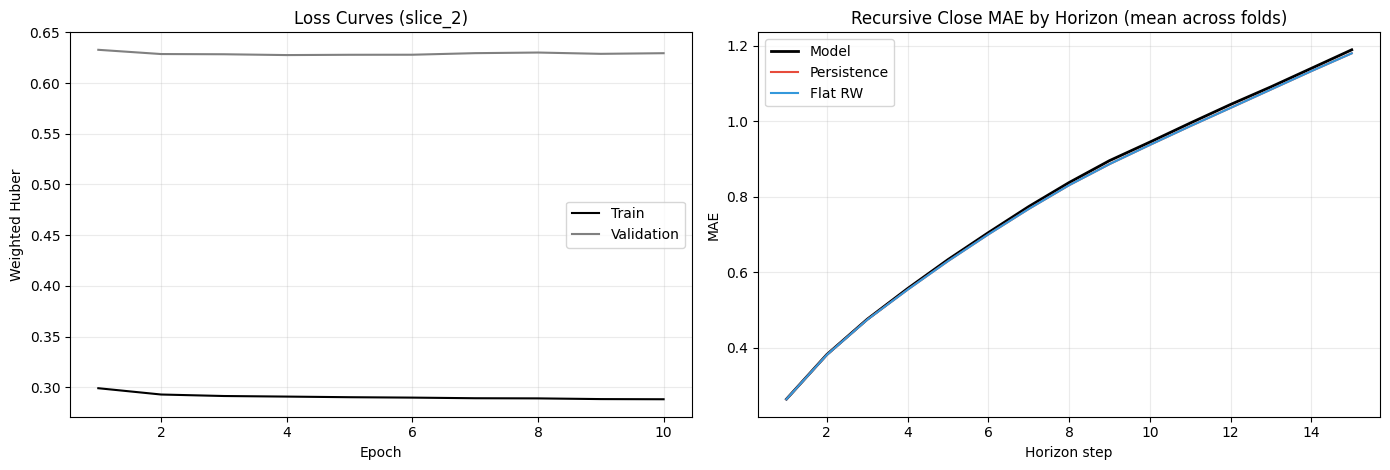

In [10]:
# Acceptance checks + diagnostic plots
latest = fold_results[-1]

mean_model_mae = float(summary_df['model_close_mae'].mean())
mean_persist_mae = float(summary_df['persistence_close_mae'].mean())
mean_dir = float(summary_df['model_directional_acc'].mean())
mean_bias = float(summary_df['model_mean_signed_bias'].mean())
mean_step15_model = float(summary_df['recursive_step15_model_mae'].mean())
mean_step15_persist = float(summary_df['recursive_step15_persistence_mae'].mean())

pred_close_path = latest['pred_future_df']['Close'].to_numpy()
is_monotonic = bool(np.all(np.diff(pred_close_path) >= 0) or np.all(np.diff(pred_close_path) <= 0))

acceptance = {
    'criterion_1_model_mae_20pct_better_than_persistence': mean_model_mae <= 0.8 * mean_persist_mae,
    'criterion_2_directional_accuracy_at_least_0_52': mean_dir >= 0.52,
    'criterion_3_step15_better_than_persistence': mean_step15_model < mean_step15_persist,
    'criterion_4_abs_bias_within_25pct_of_mae': abs(mean_bias) <= 0.25 * mean_model_mae,
    'criterion_5_non_monotonic_latest_prediction_path': not is_monotonic,
}

print('Acceptance checks:')
for k, v in acceptance.items():
    print(f'  {k}: {v}')

fig, axes = plt.subplots(1, 2, figsize=(14, 4.8), facecolor='white')

hist_df = latest['history_df']
axes[0].plot(hist_df['epoch'], hist_df['train_loss'], label='Train', color='black')
axes[0].plot(hist_df['epoch'], hist_df['val_loss'], label='Validation', color='gray')
axes[0].set_title(f"Loss Curves ({latest['fold']})")
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Weighted Huber')
axes[0].grid(alpha=0.25)
axes[0].legend()

axes[1].plot(horizon_stats['horizon'], horizon_stats['model_close_mae'], label='Model', color='black', linewidth=2.0)
axes[1].plot(horizon_stats['horizon'], horizon_stats['persistence_close_mae'], label='Persistence', color='#E74C3C')
axes[1].plot(horizon_stats['horizon'], horizon_stats['flat_close_mae'], label='Flat RW', color='#3498DB')
axes[1].set_title('Recursive Close MAE by Horizon (mean across folds)')
axes[1].set_xlabel('Horizon step')
axes[1].set_ylabel('MAE')
axes[1].grid(alpha=0.25)
axes[1].legend()

plt.tight_layout()
plt.show()


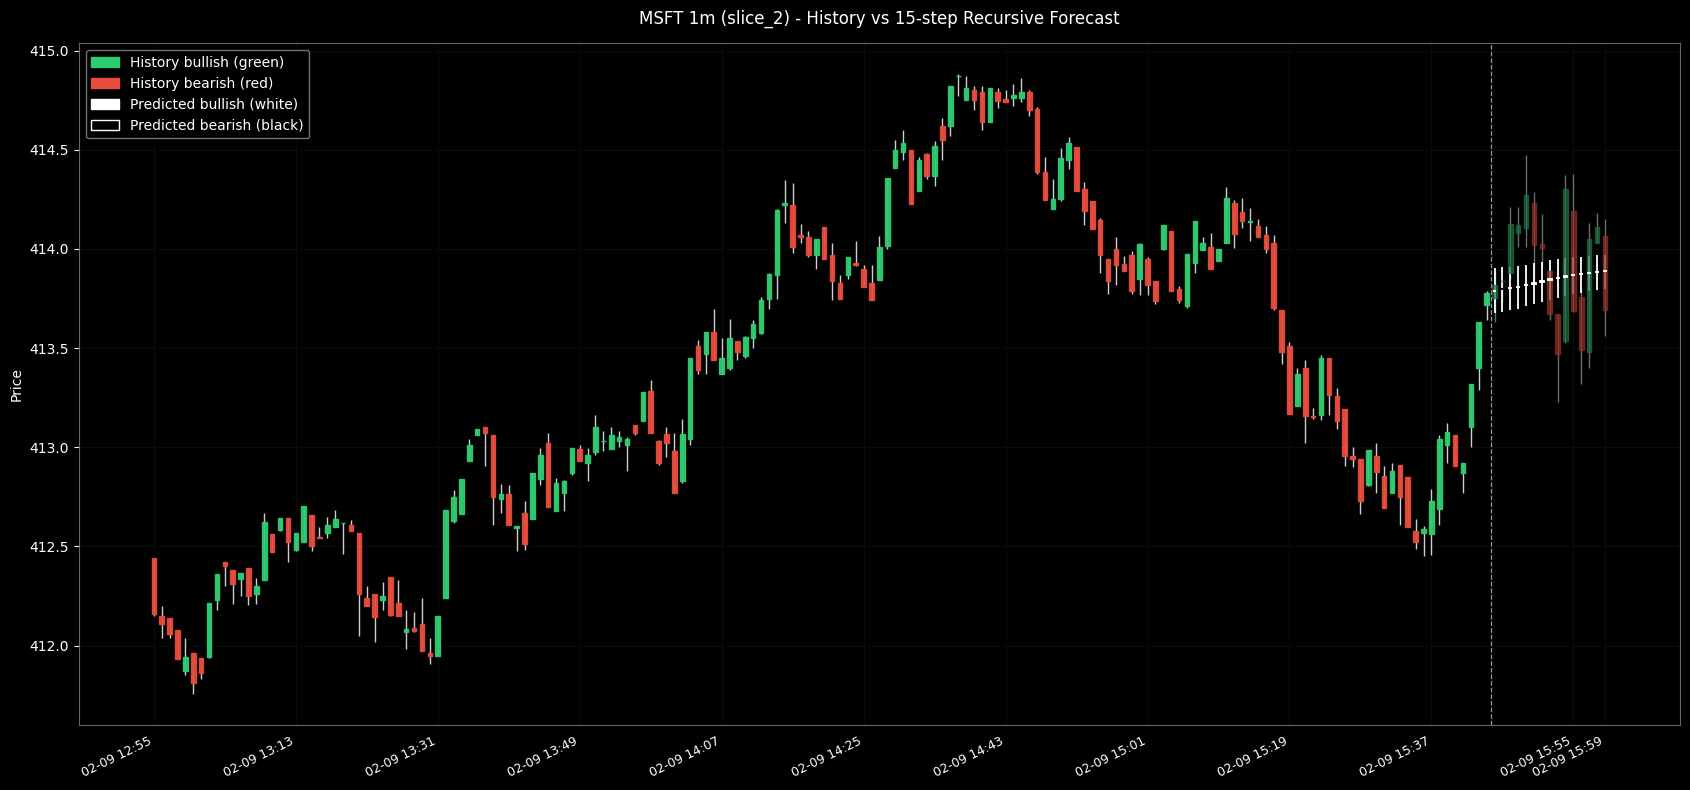

In [11]:
# Final candlestick chart: history green/red, predicted white/black
def draw_candles(
    ax,
    ohlc: pd.DataFrame,
    start_x: int,
    up_edge: str,
    up_face: str,
    down_edge: str,
    down_face: str,
    wick_color: str,
    width: float = 0.62,
    lw: float = 1.0,
    alpha: float = 1.0,
):
    values = ohlc[['Open', 'High', 'Low', 'Close']].to_numpy()

    for i, (o, h, l, c) in enumerate(values):
        x = start_x + i
        bullish = c >= o

        ax.vlines(x, l, h, color=wick_color, linewidth=lw, alpha=alpha, zorder=2)

        lower = min(o, c)
        height = abs(c - o)
        if height < 1e-8:
            height = 1e-6

        face = up_face if bullish else down_face
        edge = up_edge if bullish else down_edge

        rect = Rectangle(
            (x - width / 2, lower),
            width,
            height,
            facecolor=face,
            edgecolor=edge,
            linewidth=lw,
            alpha=alpha,
            zorder=3,
        )
        ax.add_patch(rect)


context_df = latest['context_df']
actual_future_df = latest['actual_future_df']
pred_future_df = latest['pred_future_df']

fig, ax = plt.subplots(figsize=(17, 8), facecolor='black')
ax.set_facecolor('black')

# Historical candles: green/red
draw_candles(
    ax,
    context_df,
    start_x=0,
    up_edge='#2ECC71',
    up_face='#2ECC71',
    down_edge='#E74C3C',
    down_face='#E74C3C',
    wick_color='#DADADA',
    width=0.58,
    lw=1.0,
    alpha=0.95,
)

# Actual future candles (reference): muted green/red
draw_candles(
    ax,
    actual_future_df,
    start_x=len(context_df),
    up_edge='#1D6F42',
    up_face='#1D6F42',
    down_edge='#8E2F25',
    down_face='#8E2F25',
    wick_color='#9A9A9A',
    width=0.58,
    lw=1.0,
    alpha=0.70,
)

# Predicted candles: white (bullish), black (bearish)
draw_candles(
    ax,
    pred_future_df,
    start_x=len(context_df),
    up_edge='#FFFFFF',
    up_face='#FFFFFF',
    down_edge='#000000',
    down_face='#000000',
    wick_color='#F5F5F5',
    width=0.50,
    lw=1.35,
    alpha=1.0,
)

split_x = len(context_df) - 0.5
ax.axvline(split_x, color='white', linestyle='--', linewidth=0.9, alpha=0.6)

combined_index = context_df.index.append(actual_future_df.index)
total_bars = len(combined_index)
tick_step = max(1, total_bars // 10)
ticks = list(range(0, total_bars, tick_step))
if ticks[-1] != total_bars - 1:
    ticks.append(total_bars - 1)

labels = [combined_index[i].strftime('%m-%d %H:%M') for i in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=26, ha='right', color='white', fontsize=9)

ax.tick_params(axis='y', colors='white')
for spine in ax.spines.values():
    spine.set_color('#666666')

ax.grid(color='#252525', linewidth=0.6, alpha=0.35)
ax.set_title(
    f'MSFT 1m ({latest["fold"]}) - History vs 15-step Recursive Forecast',
    color='white',
    pad=14,
)
ax.set_ylabel('Price', color='white')

legend_elements = [
    Patch(facecolor='#2ECC71', edgecolor='#2ECC71', label='History bullish (green)'),
    Patch(facecolor='#E74C3C', edgecolor='#E74C3C', label='History bearish (red)'),
    Patch(facecolor='#FFFFFF', edgecolor='#FFFFFF', label='Predicted bullish (white)'),
    Patch(facecolor='#000000', edgecolor='#FFFFFF', label='Predicted bearish (black)'),
]
leg = ax.legend(handles=legend_elements, facecolor='black', edgecolor='#707070', framealpha=1.0, loc='upper left')
for text in leg.get_texts():
    text.set_color('white')

plt.tight_layout()
plt.show()


## Notes

- This version keeps recursive forecasting (no direct multi-horizon head) per your PRD constraint.
- Targets are transformed candle-price returns (not technical indicators).
- If `delayed_sip` is unavailable for your account, notebook fails with a clear setup message by design.
- Compare model metrics against persistence/flat baselines before trusting visual fit.
- Free-plan `iex` is single-venue and can be sparse versus SIP; expect less coverage/noisier microstructure than full consolidated feeds.

